In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import src.eeg_proj.__main__ as ep
import numpy as np
import matplotlib.pyplot as plt
import mne
import numpy.typing as npt

In [3]:
%%capture
_rng = np.random.RandomState(420)
patients = ep.load_data("ds004584/")

In [4]:
psd_metrics = ep.calculate_psd_metrics(patients)

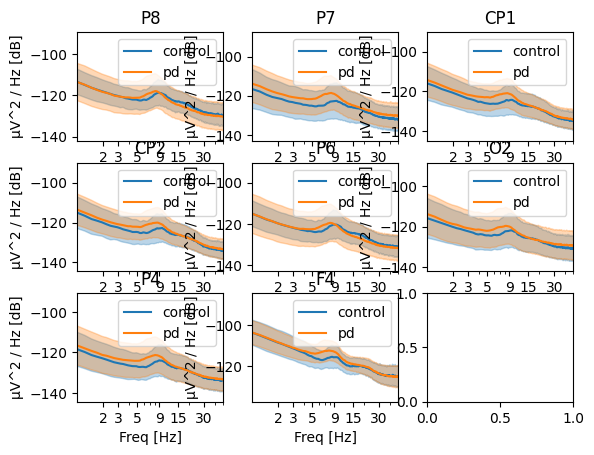

In [5]:
ep.plot_all_psd(psd_metrics)

In [335]:
y = [patient.raw.get_data(picks="P7")[0] for patient in patients]
x = [patient.raw.get_data(picks="P7", return_times=True)[1] for patient in patients]
y_normalized = [raw / np.abs(raw).max() for raw in y]
y_bandpassed = [ep.band_pass(norm, highcut=12) for norm in y_normalized]
print(y[0].shape)

(140830,)


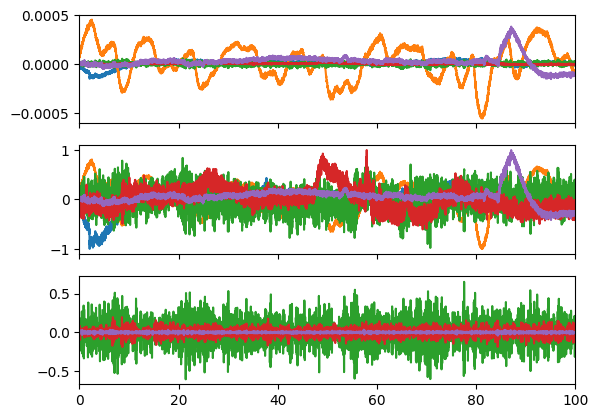

In [336]:
_, ax = plt.subplots(3, sharex=True)
for i in range(5):
    ax[0].plot(x[i], y[i])
    ax[1].plot(x[i], y_normalized[i])
    ax[2].plot(x[i], y_bandpassed[i])
    ax[2].set_xlim([0, 100])
plt.show()

In [337]:
from librosa import lpc
from scipy import signal

order = 4

a_all = [lpc(bp, order=order) for bp in y_bandpassed]
b_all = [np.hstack([[0], -1 * a[1:]]) for a in a_all]

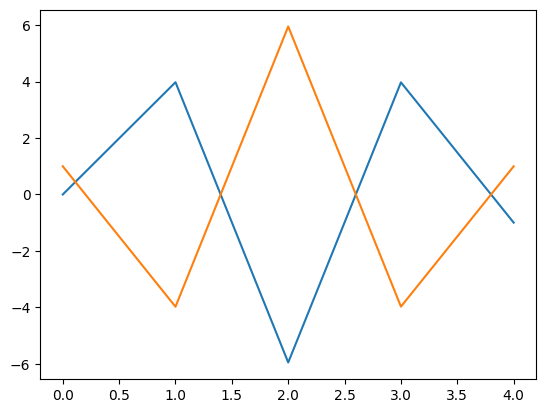

In [338]:
plt.plot(b_all[0])
plt.plot(a_all[0])

In [339]:
y_hat = [signal.filtfilt(b, [1], y_bandpassed[i]) for i, b in enumerate(b_all)]
len(y_hat)

149

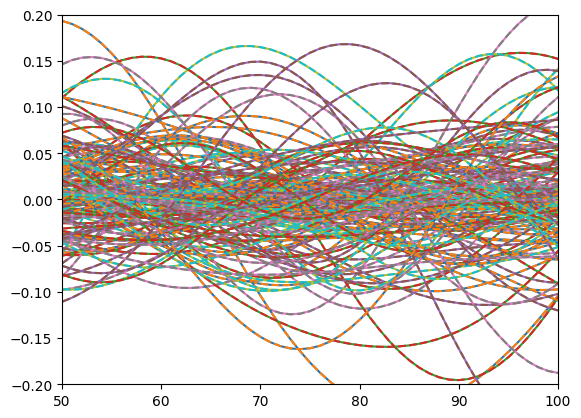

In [340]:
_, ax = plt.subplots()
for i in range(len(y_hat)):
    ax.plot(y_bandpassed[i])
    ax.plot(y_hat[i], linestyle='--')
    ax.set_xlim([50, 100])
    ax.set_ylim([-0.2, 0.2])

In [341]:
# Prediction error
y_bp = y_bandpassed[0][0:1000]
y_bp = y_bp.reshape((1, -1))
print(y_bp.shape)
hperr = np.hstack([1, -b_all[0]])
e = signal.lfilter(hperr, 1, y_bp)
e = np.matrix(e)

(1, 1000)


In [342]:
# Error power / sample
e * e.T / max(np.shape(e))

matrix([[2.41778794e-06]])

In [343]:
y_bp = np.matrix(y_bp)
y_bp * y_bp.T / max(y_bp.shape)

matrix([[0.00048686]])

In [344]:
def plot_psd(
    y,
    label: str,
    color: str,
    start=1,
    stop=14,
    FS=500,
    ax=None,
) -> None:
    if ax is None:
        _, ax = plt.subplots()
    freq_y, y_psd = signal.welch(y, FS, nperseg=1028 * 4)
    start_index = np.searchsorted(freq_y, start)
    stop_index = np.searchsorted(freq_y, stop)

    y_psd_db = 10 * np.log10(y_psd)
    ax.plot(
        freq_y[start_index:stop_index],
        y_psd_db[start_index:stop_index],
        label=label,
        color=color,
    )

[]

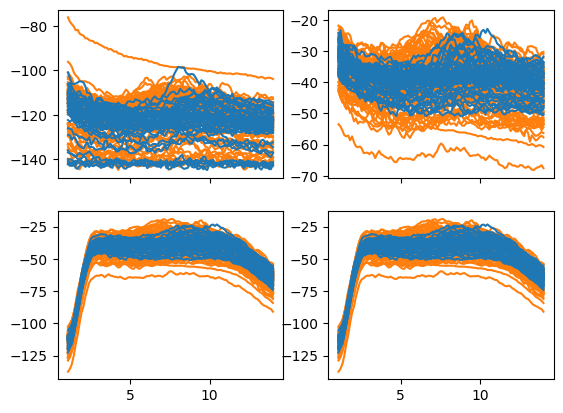

In [345]:
_, ax = plt.subplots(2, 2, sharex=True)
for i, patient in enumerate(patients):
    label = "CONTROL"
    color = "C0"
    if patient.group == "PD":
        label = "PD"
        color = "C1"
    plot_psd(
        y[i],
        label,
        color,
        ax=ax[0, 0],
    )
    plot_psd(
        y_normalized[i],
        label,
        color,
        ax=ax[0, 1],
    )
    plot_psd(
        y_bandpassed[i],
        label,
        color,
        ax=ax[1, 0],
    )
    plot_psd(
        y_hat[i],
        label,
        color,
        ax=ax[1, 1],
    )

plt.plot()

In [346]:
# Arrange feature vectors
# K x L (K - subjects in group, L order of lpc)
n = 5
X1 = np.matrix([b[1:] for b in b_all[:n]])  # Feature vector of PD group
print(X1)
X2 = np.matrix([b[1:] for b in b_all[-n:]])  # Feature vector of Control group
print(X2)
assert X1.shape == X2.shape
# X2 = [-n:]
# for patient in enumerate(patients):
print(X1.shape)

[[ 3.97830605 -5.95458856  3.9741032  -0.9978871 ]
 [ 3.97944159 -5.95668067  3.97488843 -0.99771445]
 [ 3.97681306 -5.95172811  3.97279958 -0.99798274]
 [ 3.98011347 -5.9579087   3.97533492 -0.99760135]
 [ 3.97642009 -5.95037971  3.97132976 -0.99744024]]
[[ 3.97670131 -5.95122742  3.97218461 -0.99772719]
 [ 3.97654018 -5.95104698  3.97230305 -0.9978675 ]
 [ 3.97594702 -5.94978729  3.97155186 -0.99778713]
 [ 3.97629113 -5.95046613  3.97187996 -0.99778029]
 [ 3.97667083 -5.95101065  3.97183346 -0.99756566]]
(5, 4)


In [347]:
# Calculate bias vectors
m1 = np.transpose([np.mean(x) for x in X1.T])
m2 = np.transpose([np.mean(x) for x in X2.T])

### Scaled and unbiased feature vector sets
$$Y_c = \frac{X_c - (D_c Q)^T}{\sqrt(K -1)}; c = [1, 2]; Dc = diag[p_c,1..]; Q = Ones$$

In [348]:
D1 = np.diag(m1)
D2 = np.diag(m2)

K = X1.shape[0]
Q = np.ones(X1.shape)
D1Q = np.matmul(Q, D1)
D2Q = np.matmul(Q, D2)

Y1 = (X1 - D1Q) / np.sqrt(K - 1)
Y2 = (X2 - D2Q) / np.sqrt(K - 1)

Singular value decomposition

In [349]:
U1, S1, P1 = np.linalg.svd(Y1, full_matrices=True)
U2, S2, P2 = np.linalg.svd(Y2)

Distance vectors

In [398]:
a = b_all[140][1:]

a_m1 = np.matrix(a - m1).T
a_m2 = np.matrix(a - m2).T

sum_1 = np.sum(
    [((p * a_m1) / (p * p.T)) * p for p in P1],
)
sum_2 = np.sum(
    [((p * a_m1) / (p * p.T)) * p for p in P2],
)

D1 = np.linalg.norm(a_m1 - sum_1)
D2 = np.linalg.norm(a_m2 - sum_2)

In [351]:
# Calculate leapd index
rho = D2 / (D2 + D1)
rho

0.24890294325425258

In [352]:
if rho > 0.5:
    print("Classified as PD")
else:
    print("Classified control group")

Classified control group


In [353]:
pd_group = y_bandpassed[:100]
control_group = y_bandpassed[100:]

In [356]:
import src.eeg_proj.leapd as lp

model = lp.LeapdModel(pd_group[:40], control_group[-40:], order=4)

In [357]:
correct = 0
for i, y_bp in enumerate(y_bandpassed):
    rho = model.classify(y_bp)
    if i < 100 and rho > 0.5:
        correct += 1
    elif i >= 100 and rho < 0.5:
        correct += 1
print(correct)

83


In [375]:
# TODO: Multichannel classificiation ()
# np.power(rhos , 1 / n)
root = 2
np.power(2, 1 / 2)
# np.sqrt(2)

1.4142135623730951

In [393]:
model = lp.LeapdModel(pd_group[:40], control_group[-40:], order=2)
print(model.P1)

[[-0.99992374  0.01234955]
 [ 0.01234955  0.99992374]]
